# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [69]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

lets have a look at the raw data

In [70]:
portfolio['duration'] = portfolio['duration']*24 #make duration in hours to match transaction table later
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2


first lets create numerical data out of the offer_type, since it is either ```bogo```, ```discount``` or ```informational``` . Lateron we can remove the last column since being dependant of the first two when using the dataframe for training a model.

In [71]:
# portfolio = pd.concat([portfolio, pd.get_dummies(portfolio.offer_type)[['bogo','discount','informational']]],axis=1)
# portfolio.drop('offer_type',axis=1,inplace=True)
# portfolio

lets also proceed in the same manner with the ```channels```

In [72]:
# # find all unique values of chanenls 

# unique_channels = list(set(portfolio.channels.sum())) #what are possible channels
# unique_channels= [str(channel) for channel in unique_channels] #convert to non unicode strings


# # create columns for unique values of channels and do one-hot-encoding - later we might want to reduce it by one dependant column

# for channel in unique_channels:
#     portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
# portfolio.drop('channels',axis=1, inplace=True)

# portfolio

In [73]:
# portfolio.set_index('id',inplace=True)

In [74]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2


Lets proceed with the next dataframe - profile  
here we need to make gender as separate columns and clean regarding age and income

In [75]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [76]:
profile.id = profile.id.apply(str) #convert to non unicode strings

In [77]:
len(profile[profile.age==118])

2175

In [78]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


gender and income seem to have a lot of blank values, this might be worth looking at regarding features. maybe people who do not like to give gender or income have certain tendencies. obviously age==118 correlates with gender=None and Income None

lets split became_member_on into year,month,day columns

In [79]:
def int_date_to_YMD(integer_date_YMD):
    date_string = str(integer_date_YMD)
    return date_string[:4], date_string[4:6], date_string[6:]

In [80]:
profile['member_year'] = profile['became_member_on'].apply(lambda x:int_date_to_YMD(x)[0])
profile['member_month'] = profile['became_member_on'].apply(lambda x:int_date_to_YMD(x)[1])
profile['member_day'] = profile['became_member_on'].apply(lambda x:int_date_to_YMD(x)[2])
profile.drop('became_member_on',axis=1,inplace=True)

In [81]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


maximum and average seem to tend a bit high, something worth looking at in a distribution

(array([1308., 1438., 2054., 3383., 3257., 2031.,  966.,  361.,   27.,
        2175.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

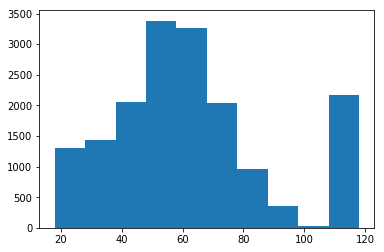

In [82]:
plt.hist(profile.age)

the average of age looks quite high for starbucks customers and the max age is probably outliers which need to be taken care of in either removing or guessing whether they substitute some other value.
first approach lets remove 118

In [83]:
profile = profile[profile.age!=118]

lets convert the male/female/other entries into columns

In [84]:
profile = pd.concat([profile, pd.get_dummies(profile.gender)[['F','M']]],axis=1)
profile.drop('gender',axis=1,inplace=True)

In [85]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
age             14825 non-null int64
id              14825 non-null object
income          14825 non-null float64
member_year     14825 non-null object
member_month    14825 non-null object
member_day      14825 non-null object
F               14825 non-null uint8
M               14825 non-null uint8
dtypes: float64(1), int64(1), object(4), uint8(2)
memory usage: 839.7+ KB


checking for double ids in dataset - obviously none

In [86]:
len(profile.id.unique())

14825

(array([1731., 1707., 2234., 2210., 2345., 1435., 1215.,  990.,  498.,
         460.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <a list of 10 Patch objects>)

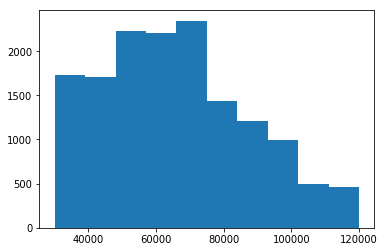

In [87]:
plt.hist(profile.dropna()['income'])

now a look onto transcript

In [88]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [89]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


In [90]:
transcript.iloc[24532]

event                                       offer completed
person                     94de646f7b6041228ca7dec82adb97d2
time                                                     30
value     {u'offer_id': u'f19421c1d4aa40978ebb69ca19b0e2...
Name: 24532, dtype: object

In [91]:
possible_keys = transcript['value'].apply(lambda x: str(list(x.keys())))
possible_keys.value_counts()

[u'amount']                 138953
[u'offer id']               134002
[u'offer_id', u'reward']     33579
Name: value, dtype: int64

In [92]:
[str(item) for item in list(transcript.event.unique())] #look at the unique non unicode strings

['offer received', 'offer viewed', 'transaction', 'offer completed']

create separate columns for offer id, amount and reward

In [93]:
transcript['offer id'] = transcript.value.apply(lambda x: x.values()[0] if 'offer' in str(x.keys()[0]) else None)
transcript['amount'] = transcript.value.apply(lambda x: x.values()[0] if (x.keys()[0])==u'amount' else None)
transcript['reward'] = transcript.value.apply(lambda x: x.values()[1] if len(x.keys())==2 else None)
transcript.drop('value',axis=1,inplace=True)

In [94]:
transcript.head(10)

,event,person,time,offer id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


check, what are customers with a high order behaviour

In [95]:
multi_order = transcript.groupby('person').count()
multi_order.sort_values('event',ascending=False,inplace=True)
multi_order.head()

,event,time,offer id,amount,reward
person,,,,,
94de646f7b6041228ca7dec82adb97d2,51,51,16,35,5
8dbfa485249f409aa223a2130f40634a,49,49,13,36,3
5e60c6aa3b834e44b822ea43a3efea26,48,48,16,32,5
d0a80415b84c4df4908b8403b19765e3,48,48,18,30,6
79d9d4f86aca4bed9290350fb43817c2,48,48,12,36,4


chose a sample customer for looking into one example behaviour

In [96]:
example_customer = multi_order.index[0]

In [97]:
#transcript[transcript['person']==example_customer].to_excel('sample_customer.xlsx')

In [98]:
#transcript[(transcript['amount']>1) | (transcript['reward']>1)].head(7)

create a temporary dataframe containing all times of offer received and offer viewed. this will be usefull for feature engineering. Due to the merge there will be data in the result where offer viewed will be before offer received. these must be removed. once this is done removing duplicate values in the time received column will make sure only adjacent events of offer received and offer viewed are counted into one event

In [99]:
df_temp_view = pd.merge(transcript[transcript['event'] == 'offer received'][['person', 'offer id', 'time']],
                 transcript[transcript['event'] == 'offer viewed'][['person', 'offer id', 'time']],
                 on=['person', 'offer id'], how='left', suffixes=[' received', ' viewed'])

df_temp_view = df_temp_view[~(df_temp_view['time viewed'] < df_temp_view['time received'])] #keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_view.drop_duplicates(['person','offer id','time received'],keep='first',inplace=True) # now that all values are removed where time viewed is smaller than time received duplicates can be removed

In [100]:
# df_sample = df_temp_view[df_temp_view['person']==example_customer].copy()
# df_sample

the same approach as before is chosen for creating a dataset considerung the time of offer completed and the reward information

In [101]:
df_temp_completed =  pd.merge(transcript[transcript['event'] == 'offer received'][['person', 'offer id', 'time']],
                 transcript[transcript['event'] == 'offer completed'][['person', 'offer id', 'time','reward']],
                 on=['person', 'offer id'], how='left', suffixes=[' received', ' completed'])


df_temp_completed = df_temp_completed[~(df_temp_completed['time completed'] < df_temp_completed['time received'])] #keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_completed.drop_duplicates(['person','offer id','time received'],keep='first',inplace=True) # now that all values are removed where time viewed is smaller than time received duplicates can be removed

# df_sample = df_temp_completed[df_temp_completed['person']==example_customer].copy()
# df_sample

now the newly created temporary frames will be merged

In [102]:
customer_offers = pd.merge(df_temp_view,
                           df_temp_completed,
                          on=['person','offer id','time received'],
                          how='left')

In [103]:
len(customer_offers)

74933

to later also use the informational offers as possible features we assume, as stated in the task, that a customer is influenced by the information for the duration time given in the portfolio dataset for each informational offer after he or she has *received* the offer. i add that he can only be influenced if he saw the offer which leads to the following processing

In [159]:
information_offers = [str(x) for x in list(portfolio[portfolio['offer_type']=='informational']['id'])]
information_offers
for offer_id in information_offers: #two informational offers are present in portfolio
    info_completion_time = portfolio[portfolio['id']==offer_id]['duration'] #each info offer has a duration
    delta_time_complete = info_completion_time.iloc[0]
    
    # time completed should be the time after receiving the info offer
    customer_offers.loc[(customer_offers['offer id']==offer_id) &\ 
                        ~(customer_offers['time viewed'].isnull()),'time completed']  = customer_offers['time received']+delta_time_complete
    
    # now if the time viewed is larger than time completed the customer cannot be have influenced by the info offer thus will be have a time completed set to nan
    customer_offers.loc[(customer_offers['offer id']==offer_id) & \
                        (customer_offers['time completed'] < customer_offers['time viewed']),'time completed'] = None   
    
    #the reward is generally 0 on info offers but should be nan if there was not even a view or the a view after the validity 
    customer_offers.loc[customer_offers['offer id']==offer_id,'reward'] = 0 * customer_offers['time completed'] #keeping nan as nan and others to 0

In [161]:
information_offers

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [162]:
customer_offers.loc[customer_offers['offer id']=='5a8bc65990b245e5a138643cd4eb9837']

,person,offer id,time received,time viewed,time completed,reward
31,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,0.0,72.0,0.0
44,a5a6ef2b78a04ddc9f374dd7c7f60bff,5a8bc65990b245e5a138643cd4eb9837,0,6.0,72.0,0.0
53,6e04a90a0e074496b5f229eb1f553433,5a8bc65990b245e5a138643cd4eb9837,0,24.0,72.0,0.0
55,a2b7a0b3487a4d779ddf4e11a034e2ee,5a8bc65990b245e5a138643cd4eb9837,0,96.0,NaN,NaN
86,1a353048b0884fc5a0afa27677ef1e80,5a8bc65990b245e5a138643cd4eb9837,0,0.0,72.0,0.0
92,4c29d22467af4d7faa137c4eedd65340,5a8bc65990b245e5a138643cd4eb9837,0,24.0,72.0,0.0
95,7c8479d8241344f6a0c306621e191c75,5a8bc65990b245e5a138643cd4eb9837,0,6.0,72.0,0.0
108,c863af14b3654499b1caea5e640136d2,5a8bc65990b245e5a138643cd4eb9837,0,0.0,72.0,0.0
155,688e4f2487d44ad8bbcc0f96936f42d6,5a8bc65990b245e5a138643cd4eb9837,0,NaN,NaN,NaN
158,e737ff591120415581ddbe817b8c82ca,5a8bc65990b245e5a138643cd4eb9837,0,0.0,72.0,0.0


In [37]:
customer_offers.loc[]

,person,offer id,time received,time viewed,time completed,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,6.0,132.0,5.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,6.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,18.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,84.0,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,60.0,5.0
6,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,0,24.0,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,NaN,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,18.0,NaN,NaN
9,31dda685af34476cad5bc968bdb01c53,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,150.0,NaN,NaN


In [58]:
transcript[transcript['person']=='a5a6ef2b78a04ddc9f374dd7c7f60bff']

,event,person,time,offer id,amount,reward
44,offer received,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
15568,offer viewed,a5a6ef2b78a04ddc9f374dd7c7f60bff,6,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
22305,transaction,a5a6ef2b78a04ddc9f374dd7c7f60bff,24,None,13.69,NaN
51351,transaction,a5a6ef2b78a04ddc9f374dd7c7f60bff,156,None,19.18,NaN
147223,transaction,a5a6ef2b78a04ddc9f374dd7c7f60bff,396,None,9.85,NaN
150643,offer received,a5a6ef2b78a04ddc9f374dd7c7f60bff,408,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
167643,offer viewed,a5a6ef2b78a04ddc9f374dd7c7f60bff,414,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
171220,transaction,a5a6ef2b78a04ddc9f374dd7c7f60bff,420,None,12.40,NaN
171221,offer completed,a5a6ef2b78a04ddc9f374dd7c7f60bff,420,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
177273,transaction,a5a6ef2b78a04ddc9f374dd7c7f60bff,432,None,18.28,NaN


In [51]:
transcript[transcript['person']==example_customer]

,event,person,time,offer id,amount,reward
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,None,7.41,NaN
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,None,1.47,NaN
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,None,2.62,NaN
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,None,0.59,NaN
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,None,2.28,NaN


looking into one specific customer the values seem plausible

In [36]:
sample2 = customer_offers[customer_offers['person']=='a5a6ef2b78a04ddc9f374dd7c7f60bff'].copy()
sample2

,person,offer id,time received,time viewed,time completed,reward
44,a5a6ef2b78a04ddc9f374dd7c7f60bff,5a8bc65990b245e5a138643cd4eb9837,0,6.0,NaN,NaN
37780,a5a6ef2b78a04ddc9f374dd7c7f60bff,2906b810c7d4411798c6938adc9daaa5,408,414.0,420.0,2.0
50285,a5a6ef2b78a04ddc9f374dd7c7f60bff,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,534.0,510.0,5.0


In [39]:
sample = customer_offers[customer_offers['person']==example_customer].copy()
sample

,person,offer id,time received,time viewed,time completed,reward
2276,94de646f7b6041228ca7dec82adb97d2,f19421c1d4aa40978ebb69ca19b0e20d,0,6.0,30.0,5.0
14938,94de646f7b6041228ca7dec82adb97d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,186.0,270.0,5.0
27481,94de646f7b6041228ca7dec82adb97d2,0b1e1539f2cc45b7b9fa7c272da2e1d7,336,NaN,492.0,5.0
39979,94de646f7b6041228ca7dec82adb97d2,fafdcd668e3743c1bb461111dcafc2a4,408,408.0,420.0,2.0
52438,94de646f7b6041228ca7dec82adb97d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,516.0,606.0,5.0
64723,94de646f7b6041228ca7dec82adb97d2,4d5c57ea9a6940dd891ad53e9dbe8da0,576,624.0,NaN,NaN


one more feature should be, how much money a person spent after he saw the offer until completing the offer

In [40]:
def sum_money_spent_in_offer(lookup_df):
    person = lookup_df['person']
    time_viewed = lookup_df['time viewed'] 
    time_completed = lookup_df['time completed']
    result = transcript[(transcript['person']==person) & (transcript['time']>time_viewed) & (transcript['time']<=time_completed)]['amount'].sum()
    return result

In [41]:
def sum_money_spent_in_offer_2(lookup_df):
    person = lookup_df['person']
    time_viewed = lookup_df['time viewed'] 
    time_completed = lookup_df['time completed']
    result = transcript[(transcript['person']==person) & (transcript['time']>time_viewed) & (transcript['time']<=time_completed)].groupby('amount').
    return result

SyntaxError: invalid syntax (<ipython-input-41-a5c1f8188771>, line 5)

In [3]:
sample_trans = transcript[:1000].copy()

In [78]:
sample_trans.groupby(by='person',agg_func='count')

TypeError: group() got an unexpected keyword argument 'agg_func'

In [58]:
speedtest = customer_offers[:200].copy()

In [63]:
%%time
speedtest['spent in offer'] = speedtest.apply(sum_money_spent_in_offer,axis=1)

CPU times: user 7.12 s, sys: 0 ns, total: 7.12 s
Wall time: 7.12 s


In [64]:
speedtest.head(5)

,person,offer id,time received,time viewed,time completed,reward,spent in offer
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,6.0,132.0,5.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,6.0,NaN,NaN,0.00
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,18.0,NaN,NaN,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,NaN,NaN,0.00
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,84.0,NaN,NaN,0.00


In [71]:
%%time
speedtest['spent in offer'] = speedtest.apply(sum_money_spent_in_offer_2,axis=1)

CPU times: user 7.13 s, sys: 0 ns, total: 7.13 s
Wall time: 7.13 s


In [72]:
speedtest.head(5)

,person,offer id,time received,time viewed,time completed,reward,spent in offer
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,6.0,132.0,5.0,<bound method DataFrameGroupBy.count of <panda...
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,6.0,NaN,NaN,<bound method DataFrameGroupBy.count of <panda...
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,18.0,NaN,NaN,<bound method DataFrameGroupBy.count of <panda...
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,NaN,NaN,<bound method DataFrameGroupBy.count of <panda...
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,84.0,NaN,NaN,<bound method DataFrameGroupBy.count of <panda...


In [49]:
customer_offers['spent in offer'] = customer_offers.apply(sum_money_spent_in_offer,axis=1)

KeyboardInterrupt: 

In [ ]:
#sample['spent in offer'] = sample.apply(lambda x:x['reward'],axis=1)

In [ ]:
sample = transcript[transcript['person']==example_customer]

In [ ]:
sample

In [ ]:
transcript.head()

In [ ]:
# transcript = pd.concat([transcript, pd.get_dummies(transcript.event)[['offer received', 'offer viewed', 'transaction', 'offer completed']]],axis=1)
# transcript.drop('event',axis=1,inplace=True)

In [ ]:
transcript.head(10)

taking a look into the person with the most received offers to get an idea on how the advertising works

In [ ]:
joined_transcript = transcript.join(portfolio,on='offer id')

In [ ]:
joined_transcript[joined_transcript.person==example_customer].head(4)

merge transcript data with portfolio data

## KPI s for person
Lets first grab a list of features that come to mind when wanting to analyze the customers behvaiour. 

- count offers received
- count offers viewed
- count transactions
- count offers completed
- total ammount spent
- view_ratio
- transaction_ratio
- completeness_ratio
- ammount spent during offer A
- ammount spent outside offer
- time being customer



In [ ]:
part = joined_transcript[['person','time','offer id','offer received','offer viewed','transaction','offer completed','amount','duration']]
part = part[part.person==example_customer]

provide a general overview on what is the high level ratios of how offers work. this does not yet look into the completenesses of an offers 'walk' from offer received -> viewed ->transaction done -> completed. this will be performed separatedly

In [ ]:
general_offer_behaviour = part.groupby(['person']).sum()
general_offer_behaviour['view_ratio'] = general_offer_behaviour['offer viewed']/general_offer_behaviour['offer received']
general_offer_behaviour['transaction_ratio'] = general_offer_behaviour['transaction']/general_offer_behaviour['offer received']
general_offer_behaviour['completness_ratio'] = general_offer_behaviour['offer completed']/general_offer_behaviour['offer received']
general_offer_behaviour.head(10)

In [ ]:
current_offer = None
offer_received = None
offer_viewed = None
offer_transaction = None
offer_completed = None
offer_list = []
reference = []
start_time = None
viewed_time = None
completed_time = None
start_time_list = []
offer_viewed_list=[]
offer_completed_time = []

for row in part.iterrows():
    if row[1]['offer received'] == 1:
        current_offer = row[1]['offer id']
        start_time = row[1]['time']
        completed_time = None
        viewed_time = None
    if row[1]['offer viewed'] == 1:
        viewed_time = row[1]['time']
    if row[1]['offer completed'] == 1:
        completed_time = row[1]['time']
        viewed_time = None
    
    
    offer_list.append(current_offer)
    start_time_list.append(start_time)
    offer_viewed_list.append(viewed_time)
    offer_completed_time.append(completed_time)
    reference = list(map(lambda x, y: str(x)+ '_' +str(y), offer_list, start_time_list))
    
part['reference offer'] = reference
part['offer completed time'] = offer_completed_time
part['offer view time'] = offer_viewed_list
part['offer active'] = (part['time'] > part['offer completed time'])
part['view active'] = ~(part['offer view time'] > part['offer completed time'])

        

In [ ]:
current_offer = None
offer_received = None
offer_viewed = None
offer_transaction = None
offer_completed = None
offer_list = []
reference = []
start_time = None
viewed_time = None
completed_time = None
start_time_list = []
offer_viewed_list=[]
offer_completed_time = []

for row in part.iterrows():
    if row[1]['offer received'] == 1:
        current_offer = row[1]['offer id']
        start_time = row[1]['time']
        completed_time = None
        viewed_time = None
    if row[1]['offer viewed'] == 1:
        viewed_time = row[1]['time']
    if row[1]['offer completed'] == 1:
        completed_time = row[1]['time']
        viewed_time = None
    
    
    offer_list.append(current_offer)
    start_time_list.append(start_time)
    offer_viewed_list.append(viewed_time)
    offer_completed_time.append(completed_time)
    reference = list(map(lambda x, y: str(x)+ '_' +str(y), offer_list, start_time_list))
    
part['reference offer'] = reference
part['start_time'] = start_time_list
part['offer completed time'] = offer_completed_time
part['offer view time'] = offer_viewed_list
part['offer active'] = ~(part['time'] > part['offer completed time'])
part['view active'] = (part['time'] > part['offer view time'])


In [ ]:
transcript.columns

In [ ]:
columns=['person','offer id','time']
times_df = pd.merge(transcript[''])

In [ ]:
part.head(35)

In [ ]:
# offer received
only_offers_received = part[part['offer received']==1]
only_offers_received

In [ ]:
# transactions during duration
for row in only_offers_received.iterrows():
    start_time = row[1]['time']
    end_time = start_time + row[1]['duration']
    print(row[1]['offer id'],
          (part[(part['time']>=start_time) & (part['time']<end_time) & part['transaction']==1])['amount'].sum())

In [ ]:
part[['person','offer active','amount']].groupby(['person','offer active'],).sum()

In [ ]:
part.to_excel('part.xlsx')

In [ ]:
part[part['offer id']=='4d5c57ea9a6940dd891ad53e9dbe8da0']

In [ ]:
part[part['offer active']==False]

In [ ]:
part[['person','offer active','view active','amount']].groupby(['person','offer active','view active'],).sum()

In [ ]:
true_offers = part[part['offer active']==True]
true_offers.head(20)

In [ ]:
walks = true_offers.drop_duplicates(subset=['offer received','offer viewed','transaction','offer completed','reference offer'],keep='first')
walks

In [ ]:
walks['reference offer'].value_counts() ==4

In [ ]:
part['time'][:5]

In [ ]:
part['offer completed time'][:5]

In [ ]:
joined_transcript[['person','offer id','time']].groupby(['person','offer id']).count()

next steps
- check in which cases one person follows the process for one offer as follows: offer received-viewd-transaction-completed
- is it possible that this shuffles?